In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import json
import requests


import geopandas
import shapely
import geoplot

from shapely.geometry import Point, Polygon
from geopandas import GeoDataFrame
from geopandas.tools import sjoin
from geoplot import polyplot
from geoplot import pointplot

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

#bokeh js
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper, LogTicker, ColorBar, LinearColorMapper, BasicTicker, PrintfTickFormatter, NumeralTickFormatter, Range1d, LabelSet, Label

from bokeh.palettes import brewer
from bokeh.transform import transform
from bokeh.layouts import row, column, gridplot
from bokeh.models.widgets import Tabs, Panel

#d3 js
from bokeh.models import GeoJSONDataSource

In [2]:
df_terr = pd.read_excel('data/soato-20_04_2022.xlsx', skiprows=3)
df_terr.info()
df_terr.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3305 entries, 0 to 3304
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   МҲОБТ коди                     3305 non-null   int64 
 1   Объектнинг номи (лотинча)      3305 non-null   object
 2   Маркази (лотинча)              177 non-null    object
 3   Объектнинг номи (кирилча)      3305 non-null   object
 4   Маркази (кирилча)              176 non-null    object
 5   Объектнинг 
рус тилидаги номи  3305 non-null   object
 6   Маркази                        176 non-null    object
dtypes: int64(1), object(6)
memory usage: 180.9+ KB


,МҲОБТ коди,Объектнинг номи (лотинча),Маркази (лотинча),Объектнинг номи (кирилча),Маркази (кирилча),Объектнинг \nрус тилидаги номи,Маркази
0,17,O‘zbekiston Respublikasi,NaN,Ўзбекистон Республикаси,NaN,Республика Узбекистан,NaN
1,1703,Andijon viloyati,Andijon sh.,Андижон вилояти,Андижон ш.,Андижанская область,г. Андижан
2,1703200,Andijon viloyatining tumanlari,NaN,Андижон вилоятининг туманлари,NaN,Районы Андижанской области,NaN
3,1703202,Oltinko‘l tumani,Oltinko‘l a.p.,Олтинкўл тумани,Олтинкўл а.п.,Алтынкульский район,нп Алтынкуль
4,1703202550,Oltinko‘l tumanining shaharchalari,NaN,Олтинкўл туманининг шаҳарчалари,NaN,Городские поселки Алтынкульского района,NaN
5,1703202552,Bo‘ston,NaN,Бўстон,NaN,Бустон,NaN
6,1703202554,Dalvarzin,NaN,Далварзин,NaN,Далварзин,NaN
7,1703202556,Jalabek,NaN,Жалабек,NaN,Жалабек,NaN
8,1703202558,Ijtimoiyat,NaN,Ижтимоият,NaN,Ижтимоият,NaN
9,1703202562,Kumakay,NaN,Кумакай,NaN,Кумакай,NaN


In [3]:
#shape file
gdf = geopandas.read_file('data/hv122zc0838.shp')
gdf.info()
gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  14 non-null     geometry
dtypes: geometry(1)
memory usage: 240.0 bytes


,geometry
0,"POLYGON ((72.35867 41.06426, 72.36182 41.06137..."
1,"POLYGON ((63.01187 41.06237, 63.02743 41.06168..."
2,"MULTIPOLYGON (((71.83483 39.98088, 71.83508 39..."
3,"POLYGON ((67.32946 41.20266, 67.34834 41.20059..."
4,"POLYGON ((58.72990 45.48672, 58.76597 45.46770..."


In [4]:
'''
0 Andijon 1703
1 Buxoro 1706
2 Ferghana 1730
3 Jizzax 1708
4 Karakalpakstan 1735
5 Kashkadarya 1710
6 Khorazm 1733
7 Namangan 1714
8 Navoi 1712
9 Samarkand 1718
10 Sirdaryo 1724
11 Surkhandarya 1722
12 Tashkent city 1726
13 Tashkent 1727

'''

'\n0 Andijon 1703\n1 Buxoro 1706\n2 Ferghana 1730\n3 Jizzax 1708\n4 Karakalpakstan 1735\n5 Kashkadarya 1710\n6 Khorazm 1733\n7 Namangan 1714\n8 Navoi 1712\n9 Samarkand 1718\n10 Sirdaryo 1724\n11 Surkhandarya 1722\n12 Tashkent city 1726\n13 Tashkent 1727\n\n'

In [5]:
#add column with region id
region_id = [1703, 1706, 1730, 1708, 1735, 1710, 1733, 1714, 1712, 1718, 1724, 1722, 1726, 1727]
gdf['region_id'] = region_id
gdf.region_id = gdf.region_id.astype('int64')


In [6]:
gdf.head()

,geometry,region_id
0,"POLYGON ((72.35867 41.06426, 72.36182 41.06137...",1703
1,"POLYGON ((63.01187 41.06237, 63.02743 41.06168...",1706
2,"MULTIPOLYGON (((71.83483 39.98088, 71.83508 39...",1730
3,"POLYGON ((67.32946 41.20266, 67.34834 41.20059...",1708
4,"POLYGON ((58.72990 45.48672, 58.76597 45.46770...",1735


In [7]:
#keep columns 0 and 5

df_terr = df_terr.iloc[:, [0, 5]]

In [8]:
df_terr.columns = ['id', 'name']

In [9]:
df_terr.head(10)

,id,name
0,17,Республика Узбекистан
1,1703,Андижанская область
2,1703200,Районы Андижанской области
3,1703202,Алтынкульский район
4,1703202550,Городские поселки Алтынкульского района
5,1703202552,Бустон
6,1703202554,Далварзин
7,1703202556,Жалабек
8,1703202558,Ижтимоият
9,1703202562,Кумакай


In [10]:
#show all 4 letter id codes
df_terr = df_terr[df_terr['id'].astype(str).str.len() == 4]

In [11]:
df_terr.head(14)

,id,name
1,1703,Андижанская область
241,1706,Бухарская область
485,1708,Джизакская область
677,1710,Кашкадарьинская область
1010,1712,Навоийская область
1153,1714,Наманганская область
1419,1718,Самаркандская область
1698,1722,Сурхандарьинская область
1986,1724,Сырдарьинская область
2114,1726,город Ташкент


In [12]:

#add new columns
df_terr['lat'] = np.nan
df_terr['lon'] = np.nan




In [13]:
for index, row in df_terr.iterrows():
    r = requests.get('https://geocode-maps.yandex.ru/1.x/?apikey=' + os.getenv('API_KEY') + '&geocode=' + row['name'] + '&format=json')
    g = r.json()
    print(g)
    df_terr.loc[index, 'lat'] = g['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos'].split(' ')[1]
    df_terr.loc[index, 'lon'] = g['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos'].split(' ')[0]

#save to json
df_terr.to_json('data/territory.json', orient='records')
    



{'response': {'GeoObjectCollection': {'metaDataProperty': {'GeocoderResponseMetaData': {'request': 'Андижанская область', 'results': '10', 'found': '1'}}, 'featureMember': [{'GeoObject': {'metaDataProperty': {'GeocoderMetaData': {'precision': 'other', 'text': 'Узбекистан, Андижанская область', 'kind': 'province', 'Address': {'country_code': 'UZ', 'formatted': 'Узбекистан, Андижанская область', 'Components': [{'kind': 'country', 'name': 'Узбекистан'}, {'kind': 'province', 'name': 'Андижанская область'}]}, 'AddressDetails': {'Country': {'AddressLine': 'Узбекистан, Андижанская область', 'CountryNameCode': 'UZ', 'CountryName': 'Узбекистан', 'AdministrativeArea': {'AdministrativeAreaName': 'Андижанская область'}}}}}, 'name': 'Андижанская область', 'description': 'Узбекистан', 'boundedBy': {'Envelope': {'lowerCorner': '71.495171 40.394496', 'upperCorner': '73.150164 41.060315'}}, 'Point': {'pos': '72.348444 40.716807'}}}]}}}
{'response': {'GeoObjectCollection': {'metaDataProperty': {'Geocode

In [14]:
df_terr = df_terr.merge(gdf, left_on='id', right_on='region_id')
df_terr.head(14)

,id,name,lat,lon,geometry,region_id
0,1703,Андижанская область,40.716807,72.348444,"POLYGON ((72.35867 41.06426, 72.36182 41.06137...",1703
1,1706,Бухарская область,40.191828,63.564412,"POLYGON ((63.01187 41.06237, 63.02743 41.06168...",1706
2,1708,Джизакская область,40.430188,67.592126,"POLYGON ((67.32946 41.20266, 67.34834 41.20059...",1708
3,1710,Кашкадарьинская область,38.681244,66.130513,"POLYGON ((65.85191 39.46346, 65.90551 39.42422...",1710
4,1712,Навоийская область,42.351559,64.233567,"POLYGON ((65.25539 43.60787, 65.26723 43.58860...",1712
5,1714,Наманганская область,40.912805,71.313639,"POLYGON ((71.70757 41.42406, 71.71663 41.41976...",1714
6,1718,Самаркандская область,39.773519,66.36659,"POLYGON ((66.71510 40.29117, 66.72923 40.29017...",1718
7,1722,Сурхандарьинская область,37.956731,67.48404,"POLYGON ((67.97571 39.03334, 67.98772 39.02164...",1722
8,1724,Сырдарьинская область,40.384364,68.711507,"POLYGON ((68.60967 40.99589, 68.61246 40.99081...",1724
9,1726,город Ташкент,41.311158,69.279737,"POLYGON ((69.33648 41.25022, 69.31113 41.23411...",1726


In [15]:
df_terr.drop('region_id', axis=1, inplace=True)

In [16]:
df = pd.read_csv('data/df.csv', sep=',')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156021 entries, 0 to 156020
Data columns (total 38 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   etp_id        156021 non-null  int64  
 1   p_avans       156021 non-null  float64
 2   avans_day     156021 non-null  float64
 3   contract_dat  156021 non-null  object 
 4   lot_date1     156021 non-null  object 
 5   lot_date2     156021 non-null  object 
 6   lot_id        156021 non-null  int64  
 7   maloy         156021 non-null  object 
 8   organ         156021 non-null  int64  
 9   proc_id       156021 non-null  int64  
 10  purpose       156021 non-null  object 
 11  raschot       156021 non-null  float64
 12  spok          156021 non-null  int64  
 13  p_summa       156021 non-null  int64  
 14  vendor_acc    156021 non-null  object 
 15  vendor_bank   156021 non-null  float64
 16  vendor_inn    156021 non-null  float64
 17  vendor_name   156021 non-null  object 
 18  vend

/var/folders/fh/yq61fqcs3q9_0k81sxnf4ff40000gn/T/ipykernel_67913/1170028243.py:1: DtypeWarning: Columns (26,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/df.csv', sep=',')


,etp_id,p_avans,avans_day,contract_dat,lot_date1,lot_date2,lot_id,maloy,organ,proc_id,...,tovar_summa,id,acc,action_name,pay_id,reg_dat,summa,response_id,request_id,contract_num
0,1,0.0,0.0,2022-08-15 05:00:00,2022-08-10 05:00:00.000000,2022-08-12 05:00:00.000000,22111008617860,Y,507000003,6,...,1380000000,67738,20208000005150641001,Утвердить,30277671,2022-08-15 05:00:00.000000,1380000000,4370278,2628882.0,546508
1,1,0.0,0.0,2022-08-15 05:00:00,2022-08-11 05:00:00.000000,2022-08-13 05:00:00.000000,22111008625670,Y,560000638,6,...,1000000020,67739,20208000604264509008,Утвердить,30277672,2022-08-15 05:00:00.000000,1000000020,4370286,2628886.0,546507
2,1,0.0,0.0,2022-08-15 05:00:00,2022-08-12 05:00:00.000000,2022-08-14 05:00:00.000000,22111008627539,Y,673000051,6,...,81386000,67741,20210000500314531001,Утвердить,30277673,2022-08-15 05:00:00.000000,81386000,4370293,2628891.0,546509
3,1,0.0,0.0,2022-08-15 05:00:00,2022-08-12 05:00:00.000000,2022-08-14 05:00:00.000000,22111008627544,Y,263,6,...,282000000,67742,23402000300100001010,Утвердить,30277674,2022-08-15 05:00:00.000000,282000000,4370294,2628892.0,546511
4,1,0.0,0.0,2022-08-15 05:00:00,2022-08-12 05:00:00.000000,2022-08-14 05:00:00.000000,22111008628182,Y,1674,6,...,2637600000,67761,20210000704995315002,Утвердить,30277695,2022-08-15 05:00:00.000000,2637600000,4370393,2628969.0,546512


In [17]:
df = df.merge(df_terr, left_on='vendor_terr', right_on='id')
df.head()

,etp_id,p_avans,avans_day,contract_dat,lot_date1,lot_date2,lot_id,maloy,organ,proc_id,...,reg_dat,summa,response_id,request_id,contract_num,id_y,name,lat,lon,geometry
0,1,0.0,0.0,2022-08-15 05:00:00,2022-08-10 05:00:00.000000,2022-08-12 05:00:00.000000,22111008617860,Y,507000003,6,...,2022-08-15 05:00:00.000000,1380000000,4370278,2628882.0,546508,1712,Навоийская область,42.351559,64.233567,"POLYGON ((65.25539 43.60787, 65.26723 43.58860..."
1,1,0.0,0.0,2022-08-15 05:00:00,2022-08-13 05:00:00.000000,2022-08-15 05:00:00.000000,22111008631384,Y,486000147,6,...,2022-08-15 05:00:00.000000,22498500,4370486,2629146.0,546532,1712,Навоийская область,42.351559,64.233567,"POLYGON ((65.25539 43.60787, 65.26723 43.58860..."
2,1,0.0,0.0,2022-08-15 05:00:00,2022-08-13 05:00:00.000000,2022-08-15 05:00:00.000000,22111008631399,Y,497000044,6,...,2022-08-15 05:00:00.000000,895000000,4370915,2629421.0,546559,1712,Навоийская область,42.351559,64.233567,"POLYGON ((65.25539 43.60787, 65.26723 43.58860..."
3,1,0.0,0.0,2022-08-15 05:00:00,2022-08-10 05:00:00.000000,2022-08-12 05:00:00.000000,22111008618881,Y,497000011,6,...,2022-08-15 05:00:00.000000,600000000,4371079,2629497.0,546582,1712,Навоийская область,42.351559,64.233567,"POLYGON ((65.25539 43.60787, 65.26723 43.58860..."
4,1,0.0,0.0,2022-08-18 05:00:00,2022-08-16 05:00:00.000000,2022-08-18 05:00:00.000000,22111008637293,Y,507000004,6,...,2022-08-18 05:00:00.000000,125000000,4441043,2674375.0,551814,1712,Навоийская область,42.351559,64.233567,"POLYGON ((65.25539 43.60787, 65.26723 43.58860..."


/Users/nilufarkhaydarova/opt/anaconda3/envs/work/lib/python3.9/site-packages/geoplot/geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


<AxesSubplot:>

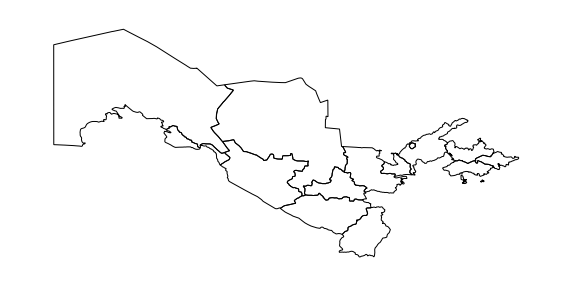

In [18]:
#plot 
geoplot.polyplot(gdf, figsize=(10, 10))

In [19]:
df = df[df['vendor_terr'] != 0]
df = df.drop(['id_x', 'id_y'], axis=1)

In [20]:
counts = df.groupby(['vendor_terr', 'name']).size().reset_index(name='counts')
counts.head(10)


,vendor_terr,name,counts
0,1703,Андижанская область,8758
1,1706,Бухарская область,8423
2,1708,Джизакская область,7373
3,1710,Кашкадарьинская область,6473
4,1712,Навоийская область,6601
5,1714,Наманганская область,11359
6,1718,Самаркандская область,11805
7,1722,Сурхандарьинская область,9952
8,1724,Сырдарьинская область,10739
9,1726,город Ташкент,33645


In [21]:
df_terr = df_terr.merge(counts, left_on='id', right_on='vendor_terr')
df_terr.head(10)


,id,name_x,lat,lon,geometry,vendor_terr,name_y,counts
0,1703,Андижанская область,40.716807,72.348444,"POLYGON ((72.35867 41.06426, 72.36182 41.06137...",1703,Андижанская область,8758
1,1706,Бухарская область,40.191828,63.564412,"POLYGON ((63.01187 41.06237, 63.02743 41.06168...",1706,Бухарская область,8423
2,1708,Джизакская область,40.430188,67.592126,"POLYGON ((67.32946 41.20266, 67.34834 41.20059...",1708,Джизакская область,7373
3,1710,Кашкадарьинская область,38.681244,66.130513,"POLYGON ((65.85191 39.46346, 65.90551 39.42422...",1710,Кашкадарьинская область,6473
4,1712,Навоийская область,42.351559,64.233567,"POLYGON ((65.25539 43.60787, 65.26723 43.58860...",1712,Навоийская область,6601
5,1714,Наманганская область,40.912805,71.313639,"POLYGON ((71.70757 41.42406, 71.71663 41.41976...",1714,Наманганская область,11359
6,1718,Самаркандская область,39.773519,66.36659,"POLYGON ((66.71510 40.29117, 66.72923 40.29017...",1718,Самаркандская область,11805
7,1722,Сурхандарьинская область,37.956731,67.48404,"POLYGON ((67.97571 39.03334, 67.98772 39.02164...",1722,Сурхандарьинская область,9952
8,1724,Сырдарьинская область,40.384364,68.711507,"POLYGON ((68.60967 40.99589, 68.61246 40.99081...",1724,Сырдарьинская область,10739
9,1726,город Ташкент,41.311158,69.279737,"POLYGON ((69.33648 41.25022, 69.31113 41.23411...",1726,город Ташкент,33645


<AxesSubplot:xlabel='name_y', ylabel='name_x'>

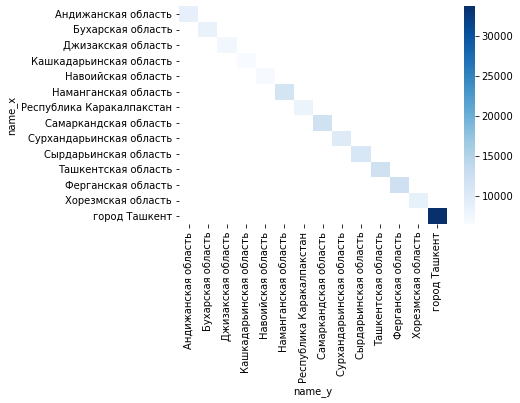

In [22]:
#df heatmap with counts of orders
sns.heatmap(df_terr.pivot_table(index='name_x', columns='name_y', values='counts', aggfunc='sum'), cmap='Blues')

In [23]:
gdf = geopandas.GeoDataFrame(df_terr, geometry=df_terr['geometry'])

In [24]:
#heatmap on map
geoplot.choropleth(gdf, hue='counts', projection=geoplot.crs.AlbersEqualArea(), figsize=(10, 10))

: 

: 

In [ ]:
#bokeh js
